# Phase 2: Dimensionality Reduction & Embedding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap

In [2]:
# Load preprocessed data (from Phase 1)
df = pd.read_csv('preprocessed_campaign_data.csv')
df.head()

,ID,Year_Birth,Education,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,Marital_Alone,Marital_Divorced,Marital_Married,Marital_Single,Marital_Together,Marital_Widow,Marital_YOLO,Customer_Tenure,Family_Size,Total_Spend
0,5524,1957,Graduation,0.336654,0,0,2012-09-04,0.305137,635,88,...,False,False,False,True,False,False,False,1.530151,-1.275199,1.704107
1,2174,1954,Graduation,-0.244749,1,1,2014-03-08,-0.386181,11,1,...,False,False,False,True,False,False,False,-1.191341,1.390634,-0.958740
2,4141,1965,Graduation,1.000925,0,0,2013-08-21,-0.800972,426,49,...,False,False,False,False,True,False,False,-0.206656,-1.275199,0.295645
3,6182,1984,Graduation,-1.215793,1,0,2014-02-10,-0.800972,11,4,...,False,False,False,False,True,False,False,-1.062688,0.057718,-0.915196
4,5324,1981,PhD,0.344295,1,0,2014-01-19,1.549510,173,43,...,False,False,True,False,False,False,False,-0.953829,0.057718,-0.297215


## Prepare Input Data (for autoencoder)

In [ ]:
# Select features for autoencoder (numeric + encoded categorical)
features = [
    'Income', 'Customer_Tenure', 'Total_Spend', 'Family_Size', 'Recency',
    'Education_encoded', 'Marital_Divorced', 'Marital_Married', 'Marital_Single',
    'Marital_Together', 'Marital_Widow'
]
X = df[features].values

# Train-test split (for validation)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Standardize (reapply scaling to ensure consistency)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Build Autoencoder

In [ ]:
input_dim = X_train.shape[1]
encoding_dim = 10  # Latent space dimension (adjustable)

# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dropout(0.2)(encoder)
encoder = Dense(32, activation='relu')(encoder)
latent_layer = Dense(encoding_dim, activation='relu')(encoder)

# Decoder
decoder = Dense(32, activation='relu')(latent_layer)
decoder = Dropout(0.2)(decoder)
decoder = Dense(64, activation='relu')(decoder)
output_layer = Dense(input_dim, activation='linear')(decoder)

# Compile
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [13]:
# Train
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9833 - val_loss: 0.8186
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7648 - val_loss: 0.5138
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5560 - val_loss: 0.3575
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4281 - val_loss: 0.2779
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3710 - val_loss: 0.2234
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3273 - val_loss: 0.1832
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2843 - val_loss: 0.1553
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2700 - val_loss: 0.1311
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2357 - val_loss: 0.1260
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2409 - val_loss: 0.1202
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2225 - val_loss: 0.1136
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2

##  Extract Latent Embeddings

In [ ]:
encoder_model = Model(inputs=input_layer, outputs=latent_layer)
train_embeddings = encoder_model.predict(X_train)
test_embeddings = encoder_model.predict(X_test)

# Combine all embeddings
embeddings = np.vstack([train_embeddings, test_embeddings])

# Save embeddings for clustering
np.save('customer_embeddings.npy', embeddings)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


## Visualize Embeddings

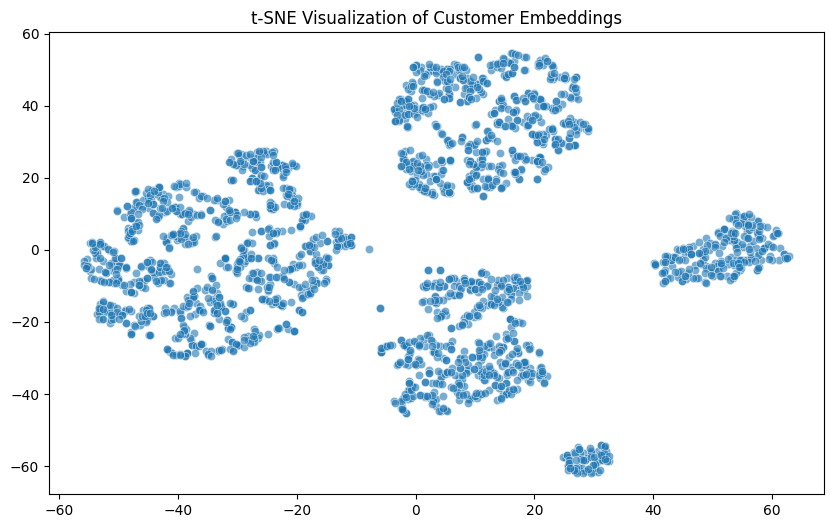

In [23]:
# t-SNE (for 2D visualization)
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], alpha=0.6)
plt.title('t-SNE Visualization of Customer Embeddings')
plt.savefig('tsne_embeddings.png')  # For report
plt.show()

<Axes: >

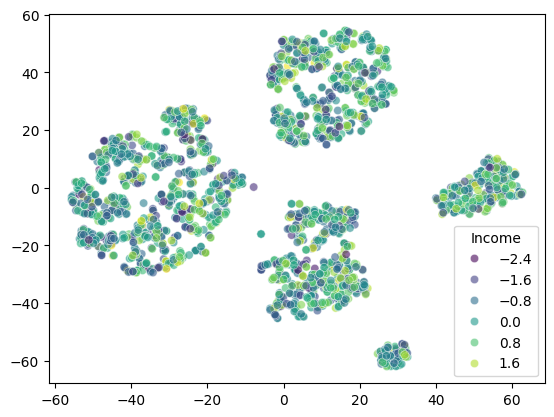

In [ ]:
# Optional (just added)
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], 
                hue=df['Total_Spend'], alpha=0.6, palette='viridis')

c:\Users\ADMIN\anaconda3\envs\cs685hw\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ADMIN\anaconda3\envs\cs685hw\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


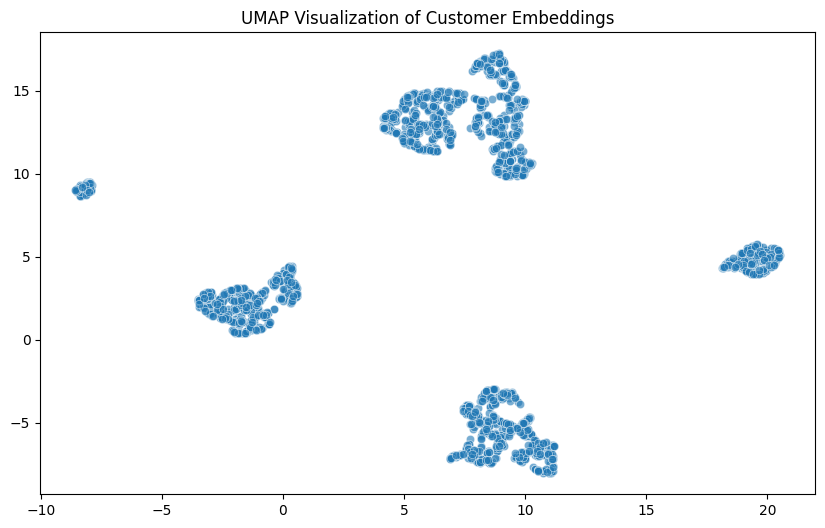

In [30]:
# UMAP (alternative to t-SNE)
umap_embeddings = umap.UMAP(random_state=42).fit_transform(embeddings)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], alpha=0.6)
plt.title('UMAP Visualization of Customer Embeddings')
plt.savefig('umap_embeddings.png')
plt.show()

## Documentation

In [8]:
print("Autoencoder Training Summary:")
print(f"- Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"- Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"- Embeddings saved to 'customer_embeddings.npy' (shape: {embeddings.shape})")

Autoencoder Training Summary:
- Final Training Loss: 0.1106
- Final Validation Loss: 0.0446
- Embeddings saved to 'customer_embeddings.npy' (shape: (2217, 10))
